In [1]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from datasets import Dataset
import pandas as pd
import pathlib

/Users/alex/Desktop/CS/Startups/Koel/ML/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('..')
from scripts.audio import audio_array_to_wav_file
from scripts.ipa import timit2ipa

In [3]:
timit = zipfile.ZipFile('../.data/TIMIT.zip', 'r')
timit_files = timit.namelist()
print(timit_files)

['PHONCODE.DOC', 'PROMPTS.TXT', 'README.DOC', 'SPKRINFO.TXT', 'SPKRSENT.TXT', 'TESTSET.DOC', 'TIMITDIC.DOC', 'TIMITDIC.TXT', 'data/TEST/DR1/FAKS0/SA1.PHN', 'data/TEST/DR1/FAKS0/SA1.TXT', 'data/TEST/DR1/FAKS0/SA1.WAV', 'data/TEST/DR1/FAKS0/SA1.WAV.wav', 'data/TEST/DR1/FAKS0/SA1.WRD', 'data/TEST/DR1/FAKS0/SA2.PHN', 'data/TEST/DR1/FAKS0/SA2.TXT', 'data/TEST/DR1/FAKS0/SA2.WAV', 'data/TEST/DR1/FAKS0/SA2.WAV.wav', 'data/TEST/DR1/FAKS0/SA2.WRD', 'data/TEST/DR1/FAKS0/SI1573.PHN', 'data/TEST/DR1/FAKS0/SI1573.TXT', 'data/TEST/DR1/FAKS0/SI1573.WAV', 'data/TEST/DR1/FAKS0/SI1573.WAV.wav', 'data/TEST/DR1/FAKS0/SI1573.WRD', 'data/TEST/DR1/FAKS0/SI2203.PHN', 'data/TEST/DR1/FAKS0/SI2203.TXT', 'data/TEST/DR1/FAKS0/SI2203.WAV', 'data/TEST/DR1/FAKS0/SI2203.WAV.wav', 'data/TEST/DR1/FAKS0/SI2203.WRD', 'data/TEST/DR1/FAKS0/SI943.PHN', 'data/TEST/DR1/FAKS0/SI943.TXT', 'data/TEST/DR1/FAKS0/SI943.WAV', 'data/TEST/DR1/FAKS0/SI943.WAV.wav', 'data/TEST/DR1/FAKS0/SI943.WRD', 'data/TEST/DR1/FAKS0/SX133.PHN', 'data/T

In [4]:
# print PHONCODE.DOC 
timit_phoncode = timit.open('PHONCODE.DOC')
for line in timit_phoncode:
    print(line.decode('utf-8').strip())

File: phoncode.doc, updated 10/12/90

This file contains a table of all the phonemic and phonetic symbols used in
the TIMIT lexicon and in the phonetic transcriptions.  These include the
stress markers {1,2} found only in the lexicon and the following symbols which
occur only in the transcriptions:

1) the closure intervals of stops which are distinguished from the stop
release.  The closure symbols for the stops b,d,g,p,t,k are
bcl,dcl,gcl,pcl,tck,kcl, respectively.  The closure portions of jh
and ch, are dcl and tcl.

2) allophones that do not occur in the lexicon.  The use of a given
allophone may be dependent on the speaker, dialect, speaking rate,
and phonemic context, among other factors.  Since the use of these
allophones is difficult to predict, they have not been used in the
phonemic transcriptions in the lexicon.

- flap dx,  such as in words "muddy" or "dirty"

- nasal flap nx, as in "winner"

- glottal stop q, which may be an allophone of t, or may mark an initial
vowel or 

In [5]:
# print PROMPTS.TXT
timit_prompts = timit.open('PROMPTS.TXT')
for line in timit_prompts:
    print(line.decode('utf-8').strip())

; File: prompts.txt, updated 10/31/88
;
; Prompt form of each TIMIT sentence-text followed by sentence type and number.
; Lines beginning with a semicolon are comments and should be ignored on
; searches.
;
She had your dark suit in greasy wash water all year. (sa1)
Don't ask me to carry an oily rag like that. (sa2)
This was easy for us. (sx3)
Jane may earn more money by working hard. (sx4)
She is thinner than I am. (sx5)
Bright sunshine shimmers on the ocean. (sx6)
Nothing is as offensive as innocence. (sx7)
Why yell or worry over silly items? (sx8)
Where were you while we were away? (sx9)
Are your grades higher or lower than Nancy's? (sx10)
He will allow a rare lie. (sx11)
Will Robin wear a yellow lily? (sx12)
Swing your arm as high as you can. (sx13)
Before Thursday's exam, review every formula. (sx14)
The museum hires musicians every evening. (sx15)
A roll of wire lay near the wall. (sx16)
Carl lives in a lively home. (sx17)
Alimony harms a divorced man's wealth. (sx18)
Aluminum si

In [6]:
# print README.DOC
timit_readme = timit.open('README.DOC')
for line in timit_readme:
    print(line.decode('utf-8').strip())

File: readme.doc, updated 10/12/90


The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus
(TIMIT)

Training and Test Data
NIST Speech Disc CD1-1.1




The TIMIT corpus of read speech has been designed to provide speech data for
the acquisition of acoustic-phonetic knowledge and for the development and
evaluation of automatic speech recognition systems.  TIMIT has resulted from
the joint efforts of several sites under sponsorship from the Defense Advanced
Research Projects Agency - Information Science and Technology Office
(DARPA-ISTO).  Text corpus design was a joint effort among the Massachusetts
Institute of Technology (MIT), Stanford Research Institute (SRI), and Texas
Instruments (TI).  The speech was recorded at TI, transcribed at MIT, and has
been maintained, verified, and prepared for CD-ROM production by the National
Institute of Standards and Technology (NIST).  This file contains a brief
description of the TIMIT Speech Corpus.  Additional information including the
refer

In [7]:
# print SPKRINFO.TXT
timit_spkrinfo = timit.open('SPKRINFO.TXT')
for line in timit_spkrinfo:
    print(line.decode('utf-8').strip())

; File: spkrinfo.txt - updated 10/15/90
;
; Table of speakers/speaker information used in DARPA TIMIT Acoustic-Phonetic
; Speech Corpus.  Lines beginning with a semicolon are comments and should be
; ignored on searches.
;
; ID - Speaker initials (of form AAAN where 'A' is alphabetic initial and 'N'
;                        is a digit 0-9 to disambiguate identical initials)
; Sex - Speaker gender (M or F)
; DR - Speaker dialect region number (1 - New England
;                                     2 - Northern
;                                     3 - North Midland
;                                     4 - South Midland
;                                     5 - Southern
;                                     6 - New York City
;                                     7 - Western
;                                     8 - Army Brat (moved around))
; Use - Data usage (TRN - System training speaker
;                   TST - System test speaker)
; RecDate - Recording date
; BirthDate - Speaker bir

In [8]:
REGIONS = ['New England', 'Northern', 'North Midland', 'South Midland', 'Southern', 'New York City', 'Western', 'Army Brat (moved around)']
records = []
for line in timit.open('SPKRINFO.TXT'):
    line = line.decode('utf-8').strip()
    if line == "" or line.startswith(';'):
        continue
    line = line.split()
    if len(line) < 10:
        line += [""] * (10 - len(line))
    records.append({
        "speaker_initials": line[0],
        "sex": line[1],
        "dialect_region": REGIONS[int(line[2]) - 1],
        "use": "Train" if line[3] == "TRN" else "Test",
        "recording_date": line[4],
        "birth_date": line[5],
        "height": line[6],
        "race": line[7],
        "education_level": line[8],
        "comments": line[9]
    })
speaker_info_df = pd.DataFrame(records)
speaker_info_df.head()

,speaker_initials,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,ABC0,M,New York City,Train,03/03/86,06/17/60,"5'11""",WHT,BS,
1,ABW0,M,Northern,Test,04/21/86,05/26/59,"5'9""",WHT,BS,
2,ADC0,M,North Midland,Train,02/25/86,04/27/54,"5'9""",WHT,HS,
3,ADD0,M,Western,Train,01/28/86,03/23/58,"6'2""",WHT,BS,
4,ADG0,F,South Midland,Test,02/12/86,04/11/59,"5'4""",WHT,MS,


In [9]:
# print SPKRSENT.TXT
timit_spkrsent = timit.open('SPKRSENT.TXT')
for line in timit_spkrsent:
    print(line.decode('utf-8').strip())

; File: spkrsent.txt, updated 10/15/90
;
; Table of TIMIT speaker IDs and the numbers of the 10 sentence-texts they read.
; These 10 sentence-texts consist of 2 "SA", 5 "SX", and 3 "SI" sentences.
; See "/timit/readme.doc" and printed documentation for more information about
; the design and selection of these sentences.  Lines beginning with a semicolon
; are comments and should be ignored on searches.
;
;ID   <SA>  <-------- SX --------->  <----- SI ----->
;---  ----  -----------------------  ----------------
ABC0  1  2  331   61  241  421  151   781  1620  2041
ABW0  1  2  134  314   44  224  404  1230  1664  2294
ADC0  1  2  287   17  197  377  107   737  1367  1997
ADD0  1  2   88  268  448  178  358   538  1295  1798
ADG0  1  2  199  379  109  289   19   649  1279  1909
AEB0  1  2   90  270  450  180  360   990  1411  2250
AEM0  1  2  312   42  222  402  132   762  1392  2022
AEO0  1  2  246  426  156  336   66  1655  1326  1956
AFM0  1  2   39  219  399  129  309   939  1569  21

In [10]:
# print TESTSET.DOC
timit_testset = timit.open('TESTSET.DOC')
for line in timit_testset:
    print(line.decode('utf-8').strip())

File: testset.doc, updated 10/11/90

TIMIT Suggested Training/Test Subdivision


The texts and speakers in TIMIT have been subdivided into suggested training
and test sets using the following criteria:

1- Roughly 20 to 30% of the corpus should be used for testing purposes,
leaving the remaining 70 to 80% for training.

2- No speaker should appear in both the training and testing portions.

3- All the dialect regions should be represented in both subsets, with
at least 1 male and 1 female speaker from each dialect.

4- The amount of overlap of text material in the two subsets should be
minimized; if possible no texts should be identical.

5- All the phonemes should be covered in the test material, preferably
each phoneme should occur multiple times in different contexts.


NOTE:  THIS TEXT SUBDIVISION HAS NO CORRESPONDENCE WITH THE ORIGINAL TRAINING
MATERIAL DISTRIBUTED ON THE PROTOTYPE CD-ROM.  Use only the designated
training material on this disc for training purposes.


Core Test S

In [11]:
# print TIMITDIC.DOC
timit_timitdic = timit.open('TIMITDIC.DOC')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

File: timitdic.doc, updated 10/11/90

TIMIT Lexicon Documentation


The dictionary found in the file "timitdic.txt" contains entries for all of
the words in the TIMIT prompts.  There are a total of 6229 entries in the
lexicon.  The lexicon was derived in part from the MIT adapted version of the
Merriam-Webster Pocket Dictionary of 1964 ("Pocket") and a preliminary version
of a general English lexicon under development at CMU.  The pronunciations in
the MIT pocket lexicon have been verified and modified over the years by
various people.  However, many of the words in the TIMIT scripts did not
appear in the pocket lexicon, and needed to be added.  These include other
forms of words found in "Pocket" and words not found in any form.  Rules were
used to generate pronunciations in the former case and the derived
pronunciations were hand-checked.  In the latter case, consisting mainly of
proper names and abbreviated forms (such as "takin'" instead of "taking" or
"'em"), the pronunciations we

In [12]:
# print TIMITDIC.TXT
timit_timitdic = timit.open('TIMITDIC.TXT')
for line in timit_timitdic:
    print(line.decode('utf-8').strip())

; timitdic.txt, updated 10/12/90
;
; This file contains a dictionary of all the words in the TIMIT
; prompts.  It is formatted so that each line contains a word in lower case
; followed by 2 blank spaces and then the quasi-phonemic transcription
; given between slashes.  For an explanation of the phonemic symbols
; see the file "phoncode.doc".  Hyphenated words appear in the
; complete form and as individual words.  Abbreviations, such as
; "mr" are followed by the punctuation ".".   Lines beginning with a semicolon
; are comments and should be ignored on searches.
;
; A few words can be found in the orthographic transcriptions that
; were not in the prompts.  These words were not included in the lexicon
; below, but are listed here for completeness.
;
; bourgeoisie  /b uh2 r zh w aa1 z iy/
; lined  /l ay1 n d/
; simmered  /s ih1 m axr d/
; teeny  /t iy1 n iy/
;
'em  /ax m/
-knacks  /n ae1 k s/
-upmanship  /ah1 p m ax n sh ih p/
-ups  /ah p s/
-zagged  /z ae1 g d/
a  /ax/
abbreviate  /

In [13]:
# list the file extensions for each data point
set(map(lambda x: x.split('.')[1], filter(lambda x: x.startswith('data/TRAIN'), timit_files)))

{'PHN', 'TXT', 'WAV', 'WRD'}

In [14]:
training_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TRAIN'), timit_files))))
print(training_files)

['data/TRAIN/DR1/MRAI0/SX72', 'data/TRAIN/DR4/MFRM0/SX165', 'data/TRAIN/DR5/MWEM0/SX330', 'data/TRAIN/DR2/MDPS0/SX449', 'data/TRAIN/DR2/MJRP0/SX405', 'data/TRAIN/DR3/MMAM0/SI1597', 'data/TRAIN/DR4/MARW0/SI1906', 'data/TRAIN/DR1/MRSO0/SA1', 'data/TRAIN/DR4/MPRK0/SX107', 'data/TRAIN/DR7/MDLM0/SX64', 'data/TRAIN/DR7/MTPR0/SI1600', 'data/TRAIN/DR7/MCLK0/SX400', 'data/TRAIN/DR5/MRAM0/SI1275', 'data/TRAIN/DR5/MPMB0/SX331', 'data/TRAIN/DR7/MTAB0/SX402', 'data/TRAIN/DR7/FJSK0/SX152', 'data/TRAIN/DR1/MKLS0/SX357', 'data/TRAIN/DR4/MESG0/SX432', 'data/TRAIN/DR4/FALR0/SX335', 'data/TRAIN/DR7/MCLK0/SA1', 'data/TRAIN/DR3/MRBC0/SX329', 'data/TRAIN/DR5/MTDP0/SX171', 'data/TRAIN/DR8/FNKL0/SX82', 'data/TRAIN/DR7/MSDB0/SX17', 'data/TRAIN/DR4/MFWK0/SX169', 'data/TRAIN/DR2/MRJH0/SX169', 'data/TRAIN/DR1/MMRP0/SA1', 'data/TRAIN/DR1/MRDD0/SX150', 'data/TRAIN/DR1/MEDR0/SX294', 'data/TRAIN/DR7/MAFM0/SX399', 'data/TRAIN/DR2/MDMT0/SA1', 'data/TRAIN/DR4/FLHD0/SI1974', 'data/TRAIN/DR3/FLAC0/SX361', 'data/TRAIN/DR3/

In [15]:
test_files = list(set(map(lambda x: x.split('.')[0], filter(lambda x: x.startswith('data/TEST'), timit_files))))
print(test_files)

['data/TEST/DR1/MDAB0/SX139', 'data/TEST/DR4/FLKD0/SA2', 'data/TEST/DR4/MTLS0/SA2', 'data/TEST/DR7/MKJL0/SA1', 'data/TEST/DR4/MTEB0/SX323', 'data/TEST/DR2/FRAM1/SI730', 'data/TEST/DR4/FCRH0/SX278', 'data/TEST/DR2/MTMR0/SX133', 'data/TEST/DR3/MCSH0/SX109', 'data/TEST/DR3/MTHC0/SI1645', 'data/TEST/DR3/MMJR0/SX298', 'data/TEST/DR4/MLJB0/SX410', 'data/TEST/DR2/FDRD1/SX194', 'data/TEST/DR2/MPGL0/SX289', 'data/TEST/DR3/MWJG0/SI494', 'data/TEST/DR4/FREW0/SX200', 'data/TEST/DR3/MMWH0/SX369', 'data/TEST/DR5/MDWA0/SI1146', 'data/TEST/DR2/FJRE0/SX36', 'data/TEST/DR5/FHES0/SI1739', 'data/TEST/DR4/MPCS0/SX189', 'data/TEST/DR1/MSJS1/SX279', 'data/TEST/DR5/FUTB0/SX394', 'data/TEST/DR2/MDLD0/SA2', 'data/TEST/DR7/MKDR0/SX283', 'data/TEST/DR3/FKMS0/SI860', 'data/TEST/DR1/MDAB0/SX229', 'data/TEST/DR3/MJJG0/SX193', 'data/TEST/DR5/MCMB0/SX8', 'data/TEST/DR4/MTLS0/SX380', 'data/TEST/DR4/MPWM0/SI1757', 'data/TEST/DR3/MTAA0/SX25', 'data/TEST/DR6/MJFC0/SI2293', 'data/TEST/DR5/FCAL1/SI1403', 'data/TEST/DR6/MDSC

In [16]:
def timit_file_to_dict(filename):
    with timit.open(filename + '.PHN') as phn_file:
        timestamped_phonemes = []
        for line in phn_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, phoneme = line.split()
            timestamped_phonemes.append((timit2ipa(phoneme), int(start) / 10_000, int(end) / 10_000))
    with timit.open(filename + '.TXT') as txt_file:
        transcription = txt_file.read().decode('utf-8').strip()
        # first two numbers are the start and end times
        transcription_start, transcription_end, *words = transcription.split()
        transcription = ' '.join(words)
    with timit.open(filename + '.WRD') as wrd_file:
        timestamped_words = []
        for line in wrd_file.read().decode('utf-8').split('\n'):
            if line == '':
                continue
            start, end, word = line.split()
            timestamped_words.append((word, int(start) / 10_000, int(end) / 10_000))
    path_segments = pathlib.Path(filename).parts
    speaker_initials = path_segments[-2][1:]
    return {'speaker_initials': speaker_initials, 'timestamped_phonemes': timestamped_phonemes, 'transcription': transcription, 'transcription_start': int(transcription_start) / 10_000, 'transcription_end': int(transcription_end) / 10_000, 'timestamped_words': timestamped_words, 'wav_filename': filename + '.WAV'}

In [17]:
def zipped_wav_to_array(filename):
    with timit.open(filename) as wav_file:
        return np.frombuffer(wav_file.read(), dtype=np.int16)

In [18]:
parsed_0 = timit_file_to_dict(training_files[0])
print(parsed_0)

{'speaker_initials': 'RAI0', 'timestamped_phonemes': [('', 0.0, 0.221), ('s', 0.221, 0.4637), ('p', 0.4637, 0.5514), ('', 0.5514, 0.614), ('ɹ', 0.614, 0.6725), ('ɪ', 0.6725, 0.7728), ('ŋ', 0.7728, 0.94), ('s', 0.94, 1.144), ('t', 1.144, 1.183), ('', 1.183, 1.293), ('ɹ', 1.293, 1.4287), ('i', 1.4287, 1.5484), ('ʔ', 1.5484, 1.6887), ('ɨ', 1.6887, 1.8088), ('ʒ', 1.8088, 2.0386), ('t', 2.0386, 2.118), ('', 2.118, 2.203), ('ɹ', 2.203, 2.278), ('eɪ', 2.278, 2.428), ('ɾ', 2.428, 2.468), ('ɛ', 2.468, 2.5942), ('ɦ', 2.5942, 2.742), ('ɛ', 2.742, 3.012), ('d', 3.012, 3.0888), ('', 3.0888, 3.104), ('ə', 3.104, 3.1645), ('', 3.1645, 3.568)], 'transcription': 'Spring Street is straight ahead.', 'transcription_start': 0.0, 'transcription_end': 3.5738, 'timestamped_words': [('spring', 0.221, 0.94), ('street', 0.94, 1.6887), ('is', 1.6887, 2.0386), ('straight', 2.0386, 2.468), ('ahead', 2.468, 3.104)], 'wav_filename': 'data/TRAIN/DR1/MRAI0/SX72.WAV'}


[106 163 -22 ...   0  -2  -2]


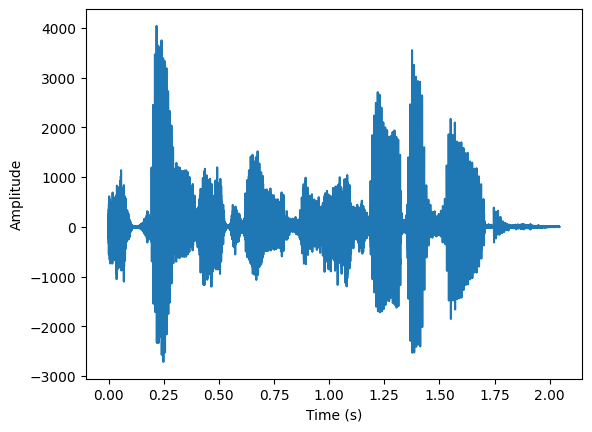

In [19]:
arr_0 = zipped_wav_to_array(parsed_0['wav_filename'])
start = parsed_0['timestamped_phonemes'][0][2]
arr_0 = arr_0[int(start * 16000):]
print(arr_0)
audio_array_to_wav_file(arr_0, '../data/TIMIT_sample_0.wav')
time = np.arange(0, len(arr_0)) / 16000
plt.plot(time, arr_0)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [20]:
def files_to_df(files):
    records = []
    for filename in files:
        parsed = timit_file_to_dict(filename)
        parsed['audio'] = zipped_wav_to_array(parsed['wav_filename'])
        del parsed['wav_filename']
        parsed['phonemes'] = [phoneme for phoneme, _, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_starts'] = [start for _, start, _ in parsed['timestamped_phonemes']]
        parsed['phoneme_ends'] = [end for _, _, end in parsed['timestamped_phonemes']]
        del parsed['timestamped_phonemes']
        parsed['words'] = [word for word, _, _ in parsed['timestamped_words']]
        parsed['word_starts'] = [start for _, start, _ in parsed['timestamped_words']]
        parsed['word_ends'] = [end for _, _, end in parsed['timestamped_words']]
        del parsed['timestamped_words']
        records.append(parsed)
    df = pd.DataFrame(records)
    return df.merge(speaker_info_df, on='speaker_initials', how='left')

In [21]:
train_df = files_to_df(training_files)
train_df.head()

,speaker_initials,transcription,transcription_start,transcription_end,audio,phonemes,phoneme_starts,phoneme_ends,words,word_starts,word_ends,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,RAI0,Spring Street is straight ahead.,0.0,3.5738,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, s, p, , ɹ, ɪ, ŋ, s, t, , ɹ, i, ʔ, ɨ, ʒ, t, ...","[0.0, 0.221, 0.4637, 0.5514, 0.614, 0.6725, 0....","[0.221, 0.4637, 0.5514, 0.614, 0.6725, 0.7728,...","[spring, street, is, straight, ahead]","[0.221, 0.94, 1.6887, 2.0386, 2.468]","[0.94, 1.6887, 2.0386, 2.468, 3.104]",M,New England,Train,03/04/86,01/02/61,"5'8""",WHT,BS,
1,FRM0,The easygoing zoologist relaxed throughout the...,0.0,4.5057,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ð, i, ʔ, i, z, ɨ, g, , oʊ, ɨ, ŋ, z, ʉ, ɑ, l...","[0.0, 0.268, 0.3, 0.3843, 0.4762, 0.588, 0.708...","[0.268, 0.3, 0.3843, 0.4762, 0.588, 0.708, 0.7...","[the, easygoing, zoologist, relaxed, throughou...","[0.268, 0.4762, 1.276, 2.1932, 2.968, 3.428, 3...","[0.3843, 1.276, 2.1932, 2.968, 3.428, 3.5174, ...",M,South Midland,Train,01/27/86,04/10/56,"5'11""",WHT,BS,NASALITY
2,WEM0,Count the number of teaspoons of soysauce that...,0.0,5.1917,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, , aʊ, n, t, ð, ə, n, ʌ, m, b, , ʌ, v, t, , ...","[0.0, 0.397, 0.469, 0.624, 0.6546, 0.767, 0.79...","[0.397, 0.469, 0.624, 0.6546, 0.767, 0.791, 0....","[count, the, number, of, teaspoons, of, soysau...","[0.397, 0.767, 0.868, 1.2808, 1.5013, 2.526, 2...","[0.767, 0.868, 1.2808, 1.5013, 2.526, 2.671, 3...",M,Southern,Train,02/19/86,02/02/57,"5'2""",BLK,BS,
3,DPS0,Ralph prepared red snapper with fresh lemon sa...,0.0,5.2122,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ɹ, aʊ, f, p, , ɹ, i, p, , ɛ, ɹ, d, ɹ, ɛ, d,...","[0.0, 0.216, 0.3581, 0.5833, 0.668, 0.766, 0.8...","[0.216, 0.3581, 0.5833, 0.668, 0.766, 0.8149, ...","[ralph, prepared, red, snapper, with, fresh, l...","[0.216, 0.668, 1.4774, 1.8064, 2.4647, 2.7601,...","[0.668, 1.4774, 1.8064, 2.4647, 2.7601, 3.348,...",M,Northern,Train,02/24/86,05/22/53,"6'1""",WHT,HS,
4,JRP0,Of course you can have another tunafish sandwich.,0.0,4.1063,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ʔ, ʌ, v, k, , ɔ, ɹ, s, ə̥, k, , ɨ, n, ɦ, æ,...","[0.0, 0.204, 0.3745, 0.4697, 0.5735, 0.6318, 0...","[0.204, 0.3745, 0.4697, 0.5735, 0.6318, 0.7227...","[of, course, you, can, have, another, tunafish...","[0.204, 0.5735, 1.1285, 1.1699, 1.4183, 1.7754...","[0.5735, 1.1285, 1.1699, 1.4183, 1.7754, 2.147...",M,Northern,Train,02/03/86,06/23/58,"5'11""",WHT,HS,


In [22]:
train_ds = Dataset.from_pandas(train_df)
print(train_ds[0])

{'speaker_initials': 'RAI0', 'transcription': 'Spring Street is straight ahead.', 'transcription_start': 0.0, 'transcription_end': 3.5738, 'audio': [18766, 21587, 12639, 2625, 8224, 12576, 12848, 2612, 24932, 24948, 24930, 25971, 26975, 8292, 29485, 8245, 18772, 18765, 2644, 24932, 24948, 24930, 25971, 30303, 29285, 26995, 28271, 11552, 13171, 12576, 12334, 29962, 29812, 29285, 28257, 25955, 26975, 8292, 29485, 8249, 24946, 12393, 29535, 14200, 2610, 26723, 28257, 25966, 24428, 28515, 28277, 8308, 26925, 12576, 29450, 28001, 27760, 24421, 28515, 28277, 8308, 26925, 13088, 14133, 14387, 29450, 28001, 27760, 24421, 24946, 25972, 11552, 8297, 13873, 12336, 2608, 24947, 28781, 25964, 27999, 28265, 11552, 8297, 12845, 12599, 2615, 24947, 28781, 25964, 27999, 30817, 11552, 8297, 12340, 12340, 29450, 28001, 27760, 24421, 24430, 31074, 25972, 8307, 26925, 12832, 29450, 28001, 27760, 24421, 31074, 25972, 26207, 29295, 24941, 8308, 29485, 8242, 12592, 29450, 28001, 27760, 24421, 26995, 24423, 26

In [25]:
test_df = files_to_df(test_files)
test_df.head()

,speaker_initials,transcription,transcription_start,transcription_end,audio,phonemes,phoneme_starts,phoneme_ends,words,word_starts,word_ends,sex,dialect_region,use,recording_date,birth_date,height,race,education_level,comments
0,DAB0,The bungalow was pleasantly situated near the ...,0.0,3.7786,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ð, ə, b, , ʌ, ŋ, g, , l̩ , oʊ, w, ʌ, z, p, ...","[0.0, 0.212, 0.2436, 0.328, 0.425, 0.457, 0.61...","[0.212, 0.2436, 0.328, 0.425, 0.457, 0.616, 0....","[the, bungalow, was, pleasantly, situated, nea...","[0.212, 0.328, 1.0694, 1.3242, 1.9509, 2.764, ...","[0.328, 1.0694, 1.3242, 1.9509, 2.764, 2.9034,...",M,New England,Test,04/21/86,12/15/62,"5'11""",WHT,BS,
1,LKD0,Don't ask me to carry an oily rag like that.,0.0,4.8436,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, , ʌ, n, æ, s, , m, i, ɾ̃, ɨ, k, , ɪ, ɹ, i, ...","[0.0, 0.215, 0.241, 0.428, 0.492, 0.7755, 0.93...","[0.215, 0.241, 0.428, 0.492, 0.7755, 0.931, 1....","[don't, ask, me, to, carry, an, oily, rag, lik...","[0.215, 0.492, 1.001, 1.1741, 1.332, 1.8214, 1...","[0.492, 0.931, 1.1741, 1.332, 1.8214, 1.9681, ...",F,South Midland,Test,02/25/86,10/02/62,"5'5""",WHT,BS,
2,TLS0,Don't ask me to carry an oily rag like that.,0.0,4.6388,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, , oʊ, n, æ, s, , m, ɨ, t, , k, , ɝ, i, ɨ, n...","[0.0, 0.95, 0.979, 1.132, 1.188, 1.375, 1.496,...","[0.95, 0.979, 1.132, 1.188, 1.375, 1.496, 1.55...","[don't, ask, me, to, carry, an, oily, rag, lik...","[0.95, 1.188, 1.556, 1.676, 1.8005, 2.2308, 2....","[1.188, 1.496, 1.676, 1.8005, 2.2308, 2.3644, ...",M,South Midland,Test,02/25/86,09/02/61,"5'11""",???,BS,
3,KJL0,She had your dark suit in greasy wash water al...,0.0,5.3352,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ʃ, i, ɦ, æ, d, , j, ɝ, d, , ɑ, ɹ, k, s, ʉ, ...","[0.0, 0.212, 0.3676, 0.46, 0.5639, 0.804, 0.86...","[0.212, 0.3676, 0.46, 0.5639, 0.804, 0.86, 0.9...","[she, had, your, dark, suit, in, greasy, wash,...","[0.212, 0.46, 0.908, 1.028, 1.508, 2.1096, 2.3...","[0.46, 0.908, 1.028, 1.508, 2.1096, 2.3812, 3....",M,Western,Test,01/20/86,11/18/55,"6'1""",WHT,MS,RECOVERING
4,TEB0,The fog prevented them from arriving on time.,0.0,4.4954,"[18766, 21587, 12639, 2625, 8224, 12576, 12848...","[, ð, ə, f, ɔ, g, , ɹ, ɨ, v, ɛ, n, ɪ, n, ð, ɛ,...","[0.0, 0.222, 0.246, 0.332, 0.555, 0.8939, 1.07...","[0.222, 0.246, 0.332, 0.555, 0.8939, 1.072, 1....","[the, fog, prevented, them, from, arriving, on...","[0.222, 0.332, 1.072, 1.8062, 2.134, 2.4731, 3...","[0.332, 1.072, 1.8062, 2.134, 2.4731, 3.3131, ...",M,South Midland,Test,01/23/86,03/07/60,"5'6""",WHT,BS,


In [26]:
test_ds = Dataset.from_pandas(test_df)
print(test_ds[0])

{'speaker_initials': 'DAB0', 'transcription': 'The bungalow was pleasantly situated near the shore.', 'transcription_start': 0.0, 'transcription_end': 3.7786, 'audio': [18766, 21587, 12639, 2625, 8224, 12576, 12848, 2612, 24932, 24948, 24930, 25971, 26975, 8292, 29485, 8245, 18772, 18765, 2644, 24932, 24948, 24930, 25971, 30303, 29285, 26995, 28271, 11552, 13171, 12576, 12334, 29962, 29812, 29285, 28257, 25955, 26975, 8292, 29485, 12337, 25632, 25185, 24368, 30835, 13105, 2617, 26723, 28257, 25966, 24428, 28515, 28277, 8308, 26925, 12576, 29450, 28001, 27760, 24421, 28515, 28277, 8308, 26925, 13088, 14135, 13880, 29450, 28001, 27760, 24421, 24946, 25972, 11552, 8297, 13873, 12336, 2608, 24947, 28781, 25964, 27999, 28265, 11552, 8297, 13357, 12852, 2613, 24947, 28781, 25964, 27999, 30817, 11552, 8297, 14645, 14389, 29450, 28001, 27760, 24421, 24430, 31074, 25972, 8307, 26925, 12832, 29450, 28001, 27760, 24421, 31074, 25972, 26207, 29295, 24941, 8308, 29485, 8242, 12592, 29450, 28001, 27